In [1]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


## Imports

In [2]:
### Libraries for Data Handling

from pathlib import Path

import numpy as np
import pandas as pd



In [3]:
### Libraries for Algorithms

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.utils


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import GridSearchCV


# Fetch Data

In [4]:
DATA_DIR = Path.cwd().parent /'data'
print(DATA_DIR)

/home/bidhya/workspace/DataMining/data


In [5]:

train = pd.read_csv(
    DATA_DIR / "swift_transaction_train_dataset/swift_transaction_train_dataset.csv", index_col="MessageId"
)
train["Timestamp"] = train["Timestamp"].astype("datetime64[ns]")
test = pd.read_csv(DATA_DIR / "swift_transaction_test_dataset/swift_transaction_test_dataset.csv", index_col="MessageId")
test["Timestamp"] = test["Timestamp"].astype("datetime64[ns]")

In [6]:
print("Training data shape",train.shape)
print("Testing data shape",test.shape)

Training data shape (4691725, 19)
Testing data shape (705108, 19)


In [7]:
print("Number of Not fraud data(0) and fraud data(1) in train data: \n",train.groupby("Label").size())
print("Number of Not fraud data(0) and fraud data(1) in test data: \n",test.groupby("Label").size())

Number of Not fraud data(0) and fraud data(1) in train data: 
 Label
0    4686825
1       4900
dtype: int64
Number of Not fraud data(0) and fraud data(1) in test data: 
 Label
0    704347
1       761
dtype: int64


# Adding Features for Model Training

In [8]:
%%time
# Hour
train["hour"] = train["Timestamp"].dt.hour
test["hour"] = test["Timestamp"].dt.hour

# Hour frequency for each sender
senders = train["Sender"].unique()
train["sender_hour"] = train["Sender"] + train["hour"].astype(str)
test["sender_hour"] = test["Sender"] + test["hour"].astype(str)
sender_hour_frequency = {}
for s in senders:
    
    sender_rows = train[train["Sender"] == s]
  
    for h in range(24):
        sender_hour_frequency[s + str(h)] = len(sender_rows[sender_rows["hour"] == h])

train["sndr_hr_freq"] = train["sender_hour"].map(sender_hour_frequency)
test["sndr_hr_freq"] = test["sender_hour"].map(sender_hour_frequency)

CPU times: user 7.61 s, sys: 504 ms, total: 8.11 s
Wall time: 8.11 s


In [9]:
%%time
# Sender-Currency Frequency and Average Amount per Sender-Currency
train["sender_currency"] = train["Sender"] + train["InstructedCurrency"]
test["sender_currency"] = test["Sender"] + test["InstructedCurrency"]

sender_currency_freq = {}
sender_currency_avg = {}

for sc in set(
    list(train["sender_currency"].unique()) + list(test["sender_currency"].unique())
):
    sender_currency_freq[sc] = len(train[train["sender_currency"] == sc])
    sender_currency_avg[sc] = train[train["sender_currency"] == sc][
        "InstructedAmount"
    ].mean()

train["sndr_curr_freq"] = train["sender_currency"].map(sender_currency_freq)
test["sndr_curr_freq"] = test["sender_currency"].map(sender_currency_freq)

train["sndr_curr_amount_average"] = train["sender_currency"].map(
    sender_currency_avg
)
test["sner_curr_at_average"] = test["sender_currency"].map(sender_currency_avg)

CPU times: user 18.5 s, sys: 536 ms, total: 19 s
Wall time: 19 s


In [10]:
%%time
# Sender-Receiver Frequency
train["sender_receiver"] = train["Sender"] + train["Receiver"]
test["sender_receiver"] = test["Sender"] + test["Receiver"]

sender_receiver_freq = {}

for sr in set(
    list(train["sender_receiver"].unique()) + list(test["sender_receiver"].unique())
):
    sender_receiver_freq[sr] = len(train[train["sender_receiver"] == sr])

train["sender_receiver_freq"] = train["sender_receiver"].map(sender_receiver_freq)
test["sender_receiver_freq"] = test["sender_receiver"].map(sender_receiver_freq)

CPU times: user 20.1 s, sys: 595 ms, total: 20.7 s
Wall time: 20.8 s


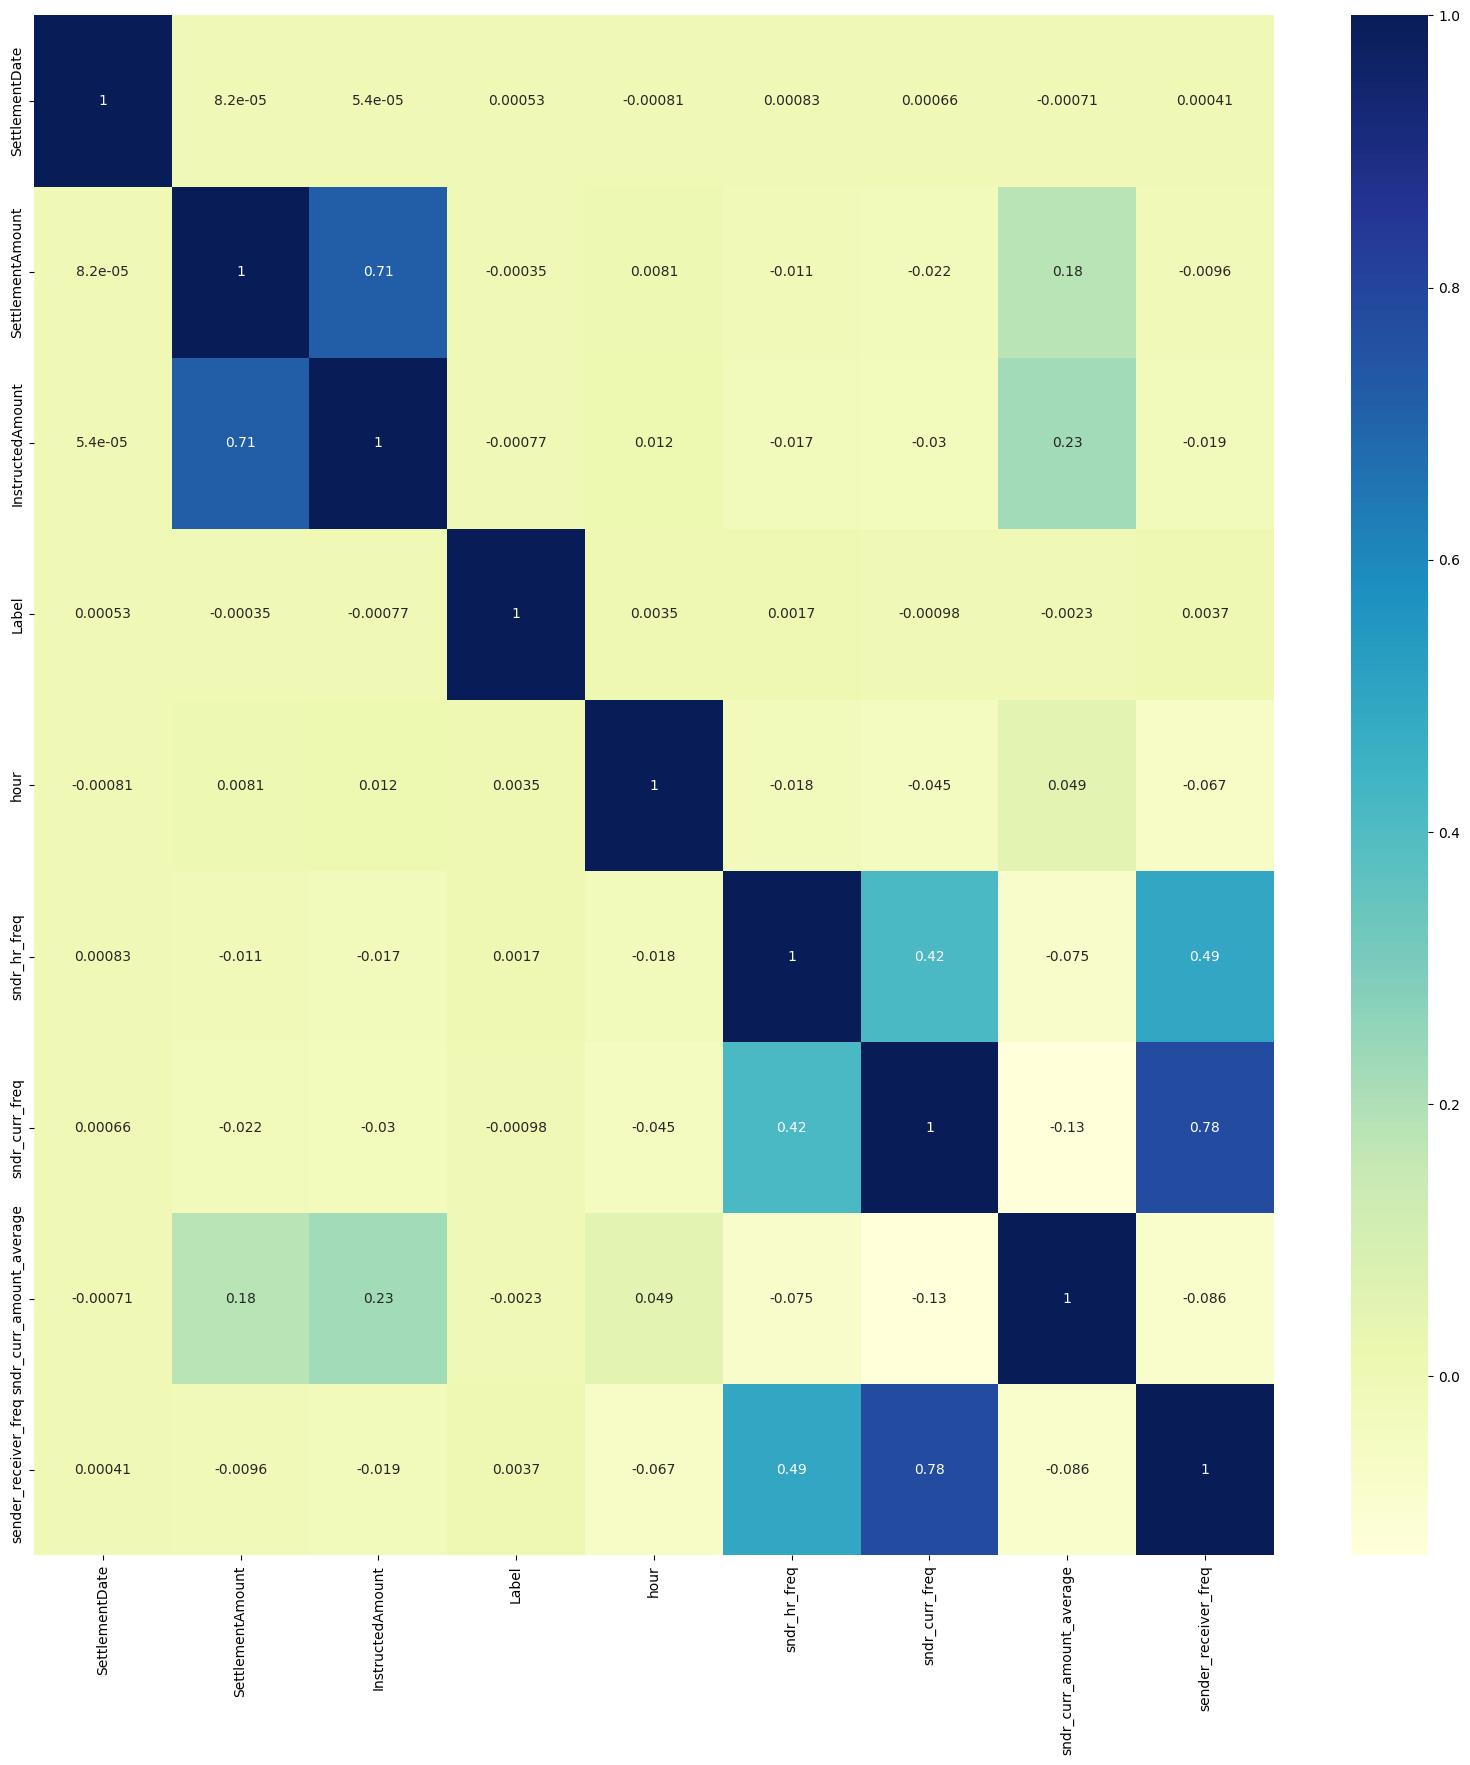

In [11]:
plt.figure(figsize=(20,20))
dataplot = sns.heatmap(train.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [12]:
print("The statistics of training data: \n")
train.describe()

The statistics of training data: 



,SettlementDate,SettlementAmount,InstructedAmount,Label,hour,sndr_hr_freq,sndr_curr_freq,sndr_curr_amount_average,sender_receiver_freq
count,4.691725e+06,4.691725e+06,4.691725e+06,4.691725e+06,4.691725e+06,4.691725e+06,4.691725e+06,4.691725e+06,4.691725e+06
mean,2.201119e+05,5.074057e+09,9.416310e+09,1.044392e-03,1.087574e+01,1.332116e+05,7.767824e+05,9.416310e+09,7.976490e+05
std,6.674533e+00,2.727637e+11,3.858898e+11,3.230018e-02,4.935320e+00,1.640939e+05,6.059924e+05,8.741206e+10,7.004966e+05
min,2.201010e+05,6.700000e-01,6.700000e-01,0.000000e+00,0.000000e+00,1.000000e+00,8.000000e+00,1.460243e+06,1.000000e+00
25%,2.201060e+05,2.237951e+06,2.174739e+06,0.000000e+00,8.000000e+00,3.136900e+04,2.740650e+05,3.691763e+06,2.407310e+05
50%,2.201120e+05,4.623860e+06,4.283423e+06,0.000000e+00,1.000000e+01,7.638800e+04,5.146270e+05,7.627898e+07,4.383750e+05
75%,2.201180e+05,1.915483e+07,1.982622e+07,0.000000e+00,1.400000e+01,1.393770e+05,1.598751e+06,1.692465e+08,1.708051e+06
max,2.201230e+05,5.646940e+13,5.650165e+13,1.000000e+00,2.300000e+01,5.523000e+05,1.598751e+06,9.285776e+11,1.708051e+06


In [13]:
print("The statistics of testing data: \n")
test.describe()

The statistics of testing data: 



,SettlementDate,SettlementAmount,InstructedAmount,Label,hour,sndr_hr_freq,sndr_curr_freq,sner_curr_at_average,sender_receiver_freq
count,705108.000000,7.051080e+05,7.051080e+05,705108.000000,705108.000000,705108.000000,7.051080e+05,7.051080e+05,7.051080e+05
mean,220127.001449,4.782674e+09,8.887403e+09,0.001079,10.869505,133475.773524,7.784326e+05,9.191849e+09,7.999296e+05
std,2.000234,2.525885e+11,3.683263e+11,0.032834,4.938199,164405.865438,6.069570e+05,8.632390e+10,7.014771e+05
min,220124.000000,3.228000e+01,2.059000e+01,0.000000,0.000000,0.000000,8.000000e+00,1.460243e+06,1.000000e+00
25%,220125.000000,2.247878e+06,2.186439e+06,0.000000,8.000000,31369.000000,2.740650e+05,3.691763e+06,2.407310e+05
50%,220127.000000,4.631815e+06,4.289023e+06,0.000000,10.000000,76388.000000,5.146270e+05,7.627898e+07,4.383750e+05
75%,220129.000000,1.934235e+07,2.006900e+07,0.000000,14.000000,139377.000000,1.598751e+06,1.692465e+08,1.708051e+06
max,220130.000000,3.804182e+13,4.012724e+13,1.000000,23.000000,552300.000000,1.598751e+06,9.285776e+11,1.708051e+06


In [14]:
# Identify number of rows with null values under each column

train.isnull().sum()


Timestamp                      0
UETR                           0
Sender                         0
Receiver                       0
TransactionReference           0
OrderingAccount                0
OrderingName                 107
OrderingStreet                 0
OrderingCountryCityZip         0
BeneficiaryAccount             0
BeneficiaryName              103
BeneficiaryStreet              0
BeneficiaryCountryCityZip      0
SettlementDate                 0
SettlementCurrency             0
SettlementAmount               0
InstructedCurrency             0
InstructedAmount               0
Label                          0
hour                           0
sender_hour                    0
sndr_hr_freq                   0
sender_currency                0
sndr_curr_freq                 0
sndr_curr_amount_average       0
sender_receiver                0
sender_receiver_freq           0
dtype: int64

In [15]:
test.isnull().sum()

Timestamp                     0
UETR                          0
Sender                        0
Receiver                      0
TransactionReference          0
OrderingAccount               0
OrderingName                  8
OrderingStreet                0
OrderingCountryCityZip        0
BeneficiaryAccount            0
BeneficiaryName              20
BeneficiaryStreet             0
BeneficiaryCountryCityZip     0
SettlementDate                0
SettlementCurrency            0
SettlementAmount              0
InstructedCurrency            0
InstructedAmount              0
Label                         0
hour                          0
sender_hour                   0
sndr_hr_freq                  0
sender_currency               0
sndr_curr_freq                0
sner_curr_at_average          0
sender_receiver               0
sender_receiver_freq          0
dtype: int64

# Handling Missing values

In [16]:
train['OrderingName'].fillna(train['OrderingName'].mode().values[0],inplace=True)
train['BeneficiaryName'].fillna(train['BeneficiaryName'].mode().values[0],inplace=True)
test['OrderingName'].fillna(test['OrderingName'].mode().values[0],inplace=True)
test['BeneficiaryName'].fillna(test['BeneficiaryName'].mode().values[0],inplace=True)

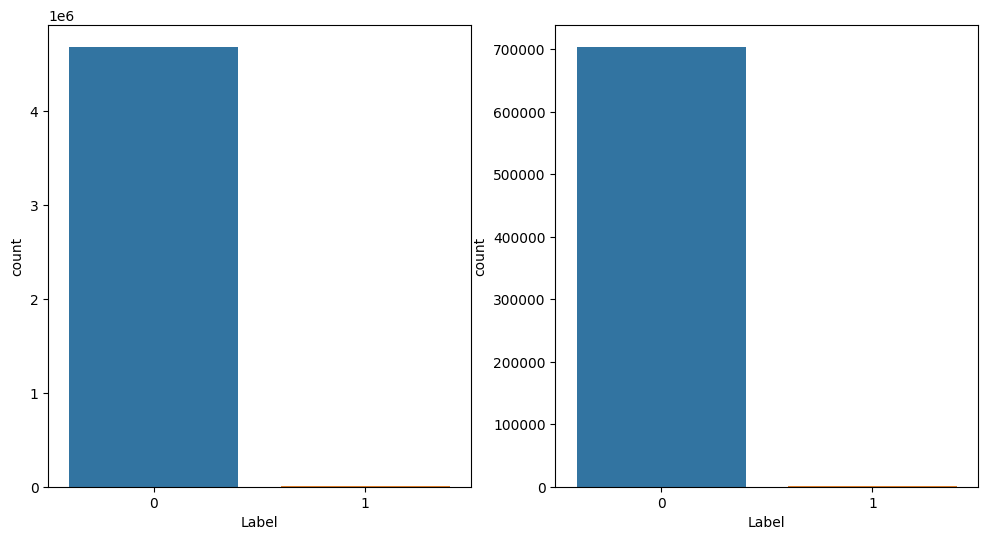

In [17]:

f, axes = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(x='Label',data=train, ax=axes[0]);
sns.countplot(x='Label',data=test, ax=axes[1]);
plt.show()




In [18]:
# Excluding categorical columns for training and testing

columns_to_drop = [
    "UETR",
    "Sender",
    "Receiver",
    "TransactionReference",
    "OrderingAccount",
    "OrderingName",
    "OrderingStreet",
    "OrderingCountryCityZip",
    "BeneficiaryAccount",
    "BeneficiaryName",
    "BeneficiaryStreet",
    "BeneficiaryCountryCityZip",
    "SettlementDate",
    "SettlementCurrency",
    "InstructedCurrency",
    "Timestamp",
    "sender_hour",
    "sender_currency",
    "sender_receiver",
]

train = train.drop(columns_to_drop, axis=1)
test = test.drop(columns_to_drop, axis=1)


# Separate Label

In [19]:
y_train1 = train["Label"].values
y_test1 = test["Label"].values

X_train1 = train.drop(["Label"], axis=1).values
X_test1 = test.drop(["Label"], axis=1).values

# Normalize

In [20]:
# Normalize

scaler = StandardScaler()
scaler.fit(X_train1)

X_train1 = scaler.transform(X_train1)
X_test1 = scaler.transform(X_test1)

# Undersampling the majority class using Random Under Sampler

In [21]:
rus1 = RandomUnderSampler(sampling_strategy=0.10)
X_under_train1, y_under_train1 = rus1.fit_resample(X_train1, y_train1)
X_under_test1, y_under_test1 = rus1.fit_resample(X_test1, y_test1)
print(Counter(y_train1))
print(Counter(y_test1))
print(Counter(y_under_train1))
print(Counter(y_under_test1))

Counter({0: 4686825, 1: 4900})
Counter({0: 704347, 1: 761})
Counter({0: 49000, 1: 4900})
Counter({0: 7610, 1: 761})


# Oversampling the minority class using SMOTE

In [22]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_under_train1, y_under_train1 )
X_test, y_test = sm.fit_resample(X_under_test1, y_under_test1 )
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 49000, 1: 49000})
Counter({0: 7610, 1: 7610})


# Logistic Regression

In [23]:
%%time

lr1 = LogisticRegression()
lr1.fit(X_train1, y_train1)

CPU times: user 22.1 s, sys: 18 s, total: 40.1 s
Wall time: 5.9 s


LogisticRegression()

In [24]:
pred_lr1 = lr1.predict(X_test1)
print("Logistic Regression Classification Report\n", classification_report(y_test1, pred_lr1))
print("Logistic Regression Confusion Matrix\n", confusion_matrix(y_test1, pred_lr1))
pred_proba_lr1 = lr1.predict_proba(X_test1)[:, 1]
print("\n")
print("AUPRC:", metrics.average_precision_score(y_true=y_test1, y_score=pred_proba_lr1))
print("\n")

/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Logistic Regression Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    704347
           1       0.00      0.00      0.00       761

    accuracy                           1.00    705108
   macro avg       0.50      0.50      0.50    705108
weighted avg       1.00      1.00      1.00    705108

Logistic Regression Confusion Matrix
 [[704347      0]
 [   761      0]]


AUPRC: 0.0032507680813957857




## Logistic Regression with balanced dataset

In [25]:
%%time

lr = LogisticRegression(penalty='l2')
lr.fit(X_train, y_train)
pred_lr = lr1.predict(X_test)
print("Logistic Regression Classification Report with sample data \n\n", classification_report(y_test, pred_lr))
print("Logistic Regression Confusion Matrix \n\n", confusion_matrix(y_test, pred_lr))
pred_proba_lr = lr.predict_proba(X_test)[:, 1]
print("\n")
print("AUPRC:", metrics.average_precision_score(y_true=y_test, y_score=pred_proba_lr))
print("\n")

Logistic Regression Classification Report with sample data 

               precision    recall  f1-score   support

           0       0.50      1.00      0.67      7610
           1       0.00      0.00      0.00      7610

    accuracy                           0.50     15220
   macro avg       0.25      0.50      0.33     15220
weighted avg       0.25      0.50      0.33     15220

Logistic Regression Confusion Matrix 

 [[7610    0]
 [7610    0]]


AUPRC: 0.6780626905750542


CPU times: user 356 ms, sys: 666 ms, total: 1.02 s
Wall time: 144 ms


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

## Logistic Regression with hyperparameter tuning

In [26]:
%%time

lr_best= LogisticRegression()

param_grid = {"penalty" : ['l1','12',None],"C" : np.logspace(-4, 4, 20),"solver" : ["lbfgs","newton-cg","liblinear"],"max_iter" : [100, 1000,2500]}
lr_tune = GridSearchCV(lr_best, param_grid = param_grid, cv = 3, verbose=3)
best_lr = lr_tune.fit(X_train, y_train )
best_lr.best_estimator_


Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[CV 1/3] END C=0.0001, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.0001, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.0001, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=0.0001, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=0.0001, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=0.0001, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=0.0001, max_iter=100, penalty=l1, solver=liblinear;, score=0.500 total time=   0.0s
[CV 2/3] END C=0.0001, max_iter=100, penalty=l1, solver=liblinear;, score=0.500 total time=   0.0s
[CV 3/3] END C=0.0001, max_iter=100, penalty=l1, solver=liblinear;, score=0.500 total time=   0.0s
[CV 1/3] END C=0.0001, max_iter=100, penalty=12, solver=lbfgs;, score

[CV 1/3] END C=0.00026366508987303583, max_iter=100, penalty=l1, solver=liblinear;, score=0.500 total time=   0.0s
[CV 2/3] END C=0.00026366508987303583, max_iter=100, penalty=l1, solver=liblinear;, score=0.500 total time=   0.0s
[CV 3/3] END C=0.00026366508987303583, max_iter=100, penalty=l1, solver=liblinear;, score=0.500 total time=   0.1s
[CV 1/3] END C=0.00026366508987303583, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.00026366508987303583, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.00026366508987303583, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=0.00026366508987303583, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=0.00026366508987303583, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=0.00026366508987303583, max_iter=100, penalty=12, solver=newton-cg;, score=nan total ti

[CV 2/3] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=liblinear;, score=0.509 total time=   0.0s
[CV 2/3] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=liblinear;, score=0.510 total time=   0.0s
[CV 3/3] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=liblinear;, score=0.513 total time=   0.1s
[CV 1/3] END C=0.0006951927961775605, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.0006951927961775605, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.0006951927961775605, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=0.0006951927961775605, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0

[CV 2/3] END C=0.0018329807108324356, max_iter=100, penalty=l1, solver=liblinear;, score=0.521 total time=   0.1s
[CV 3/3] END C=0.0018329807108324356, max_iter=100, penalty=l1, solver=liblinear;, score=0.523 total time=   0.1s
[CV 1/3] END C=0.0018329807108324356, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.0018329807108324356, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.0018329807108324356, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=0.0018329807108324356, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=0.0018329807108324356, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=0.0018329807108324356, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=0.0018329807108324356, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s


[CV 2/3] END C=0.004832930238571752, max_iter=100, penalty=l1, solver=liblinear;, score=0.536 total time=   0.1s
[CV 3/3] END C=0.004832930238571752, max_iter=100, penalty=l1, solver=liblinear;, score=0.537 total time=   0.1s
[CV 1/3] END C=0.004832930238571752, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.004832930238571752, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.004832930238571752, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=0.004832930238571752, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=0.004832930238571752, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=0.004832930238571752, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=0.004832930238571752, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] 

[CV 2/3] END C=0.012742749857031334, max_iter=100, penalty=l1, solver=liblinear;, score=0.537 total time=   0.1s
[CV 3/3] END C=0.012742749857031334, max_iter=100, penalty=l1, solver=liblinear;, score=0.541 total time=   0.1s
[CV 1/3] END C=0.012742749857031334, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.012742749857031334, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.012742749857031334, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=0.012742749857031334, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=0.012742749857031334, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=0.012742749857031334, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=0.012742749857031334, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] 

/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.03359818286283781, max_iter=100, penalty=l1, solver=liblinear;, score=0.577 total time=   2.9s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=0.03359818286283781, max_iter=100, penalty=l1, solver=liblinear;, score=0.571 total time=   2.5s
[CV 3/3] END C=0.03359818286283781, max_iter=100, penalty=l1, solver=liblinear;, score=0.581 total time=   2.8s
[CV 1/3] END C=0.03359818286283781, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.03359818286283781, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.03359818286283781, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=0.03359818286283781, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=0.03359818286283781, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=0.03359818286283781, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=0.03359818286283781, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.0

[CV 1/3] END C=0.08858667904100823, max_iter=100, penalty=l1, solver=liblinear;, score=0.601 total time=   6.5s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=0.08858667904100823, max_iter=100, penalty=l1, solver=liblinear;, score=0.603 total time=   6.4s
[CV 3/3] END C=0.08858667904100823, max_iter=100, penalty=l1, solver=liblinear;, score=0.612 total time=   5.8s
[CV 1/3] END C=0.08858667904100823, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.08858667904100823, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.08858667904100823, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=0.08858667904100823, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=0.08858667904100823, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=0.08858667904100823, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=0.08858667904100823, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.0

[CV 1/3] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=liblinear;, score=0.610 total time=   4.1s
[CV 2/3] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=liblinear;, score=0.613 total time=   7.7s
[CV 3/3] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=liblinear;, score=0.617 total time=   2.9s
[CV 1/3] END C=0.23357214690901212, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.23357214690901212, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.23357214690901212, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=0.23357214690901212, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=0.23357214690901212, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=0.23357214690901212, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=0

/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=0.615848211066026, max_iter=100, penalty=l1, solver=liblinear;, score=0.615 total time=   6.2s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=0.615848211066026, max_iter=100, penalty=l1, solver=liblinear;, score=0.640 total time=   7.1s
[CV 3/3] END C=0.615848211066026, max_iter=100, penalty=l1, solver=liblinear;, score=0.642 total time=   4.3s
[CV 1/3] END C=0.615848211066026, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=0.615848211066026, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=0.615848211066026, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=0.615848211066026, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=0.615848211066026, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=0.615848211066026, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=0.615848211066026, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.615848211066026, ma

[CV 1/3] END C=1.623776739188721, max_iter=100, penalty=l1, solver=liblinear;, score=0.640 total time=   2.6s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1.623776739188721, max_iter=100, penalty=l1, solver=liblinear;, score=0.641 total time=   3.1s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=1.623776739188721, max_iter=100, penalty=l1, solver=liblinear;, score=0.642 total time=   2.2s
[CV 1/3] END C=1.623776739188721, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1.623776739188721, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1.623776739188721, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=1.623776739188721, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=1.623776739188721, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=1.623776739188721, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=1.623776739188721, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1.623776739188721, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1.623776739188721, max_

/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=4.281332398719396, max_iter=100, penalty=l1, solver=liblinear;, score=0.639 total time=   2.7s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=4.281332398719396, max_iter=100, penalty=l1, solver=liblinear;, score=0.642 total time=   4.9s
[CV 3/3] END C=4.281332398719396, max_iter=100, penalty=l1, solver=liblinear;, score=0.642 total time=   3.2s
[CV 1/3] END C=4.281332398719396, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=4.281332398719396, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=4.281332398719396, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=4.281332398719396, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=4.281332398719396, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=4.281332398719396, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=4.281332398719396, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=4.281332398719396, ma

[CV 1/3] END C=11.288378916846883, max_iter=100, penalty=l1, solver=liblinear;, score=0.640 total time=   4.9s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=11.288378916846883, max_iter=100, penalty=l1, solver=liblinear;, score=0.642 total time=   6.5s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=11.288378916846883, max_iter=100, penalty=l1, solver=liblinear;, score=0.643 total time=   3.7s
[CV 1/3] END C=11.288378916846883, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=11.288378916846883, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=11.288378916846883, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=11.288378916846883, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=11.288378916846883, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=11.288378916846883, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=11.288378916846883, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=11.288378916846883, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=11.28837891684

[CV 1/3] END C=29.763514416313132, max_iter=100, penalty=l1, solver=liblinear;, score=0.640 total time=   2.3s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=29.763514416313132, max_iter=100, penalty=l1, solver=liblinear;, score=0.642 total time=   2.8s
[CV 3/3] END C=29.763514416313132, max_iter=100, penalty=l1, solver=liblinear;, score=0.643 total time=   2.6s
[CV 1/3] END C=29.763514416313132, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=29.763514416313132, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=29.763514416313132, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=29.763514416313132, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=29.763514416313132, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=29.763514416313132, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=29.763514416313132, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=29.763514416

[CV 1/3] END C=78.47599703514607, max_iter=100, penalty=l1, solver=liblinear;, score=0.640 total time=   3.2s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=78.47599703514607, max_iter=100, penalty=l1, solver=liblinear;, score=0.642 total time=   3.5s
[CV 3/3] END C=78.47599703514607, max_iter=100, penalty=l1, solver=liblinear;, score=0.643 total time=   3.0s
[CV 1/3] END C=78.47599703514607, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=78.47599703514607, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=78.47599703514607, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=78.47599703514607, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=78.47599703514607, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=78.47599703514607, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=78.47599703514607, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=78.47599703514607, ma

[CV 1/3] END C=206.913808111479, max_iter=100, penalty=l1, solver=liblinear;, score=0.640 total time=   4.6s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=206.913808111479, max_iter=100, penalty=l1, solver=liblinear;, score=0.642 total time=   6.8s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=206.913808111479, max_iter=100, penalty=l1, solver=liblinear;, score=0.643 total time=   2.2s
[CV 1/3] END C=206.913808111479, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=206.913808111479, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=206.913808111479, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=206.913808111479, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=206.913808111479, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=206.913808111479, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=206.913808111479, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=206.913808111479, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=206.913808111479, max_iter=100, 

[CV 1/3] END C=545.5594781168514, max_iter=100, penalty=l1, solver=liblinear;, score=0.640 total time=   4.4s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=545.5594781168514, max_iter=100, penalty=l1, solver=liblinear;, score=0.642 total time=   4.3s
[CV 3/3] END C=545.5594781168514, max_iter=100, penalty=l1, solver=liblinear;, score=0.643 total time=   3.5s
[CV 1/3] END C=545.5594781168514, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=545.5594781168514, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=545.5594781168514, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=545.5594781168514, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=545.5594781168514, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=545.5594781168514, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=545.5594781168514, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=545.5594781168514, ma

/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END C=1438.44988828766, max_iter=100, penalty=l1, solver=liblinear;, score=0.640 total time=   3.8s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=1438.44988828766, max_iter=100, penalty=l1, solver=liblinear;, score=0.642 total time=   6.3s
[CV 3/3] END C=1438.44988828766, max_iter=100, penalty=l1, solver=liblinear;, score=0.643 total time=   4.1s
[CV 1/3] END C=1438.44988828766, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=1438.44988828766, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=1438.44988828766, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=1438.44988828766, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=1438.44988828766, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=1438.44988828766, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=1438.44988828766, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1438.44988828766, max_iter=100

[CV 1/3] END C=3792.690190732246, max_iter=100, penalty=l1, solver=liblinear;, score=0.640 total time=   2.4s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=3792.690190732246, max_iter=100, penalty=l1, solver=liblinear;, score=0.642 total time=   4.0s
[CV 3/3] END C=3792.690190732246, max_iter=100, penalty=l1, solver=liblinear;, score=0.643 total time=   2.2s
[CV 1/3] END C=3792.690190732246, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=3792.690190732246, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=3792.690190732246, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=3792.690190732246, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=3792.690190732246, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=3792.690190732246, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=3792.690190732246, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=3792.690190732246, ma

[CV 1/3] END C=10000.0, max_iter=100, penalty=l1, solver=liblinear;, score=0.640 total time=   3.0s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END C=10000.0, max_iter=100, penalty=l1, solver=liblinear;, score=0.642 total time=   4.8s


/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END C=10000.0, max_iter=100, penalty=l1, solver=liblinear;, score=0.643 total time=   2.7s
[CV 1/3] END C=10000.0, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END C=10000.0, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END C=10000.0, max_iter=100, penalty=12, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=10000.0, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=10000.0, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=10000.0, max_iter=100, penalty=12, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=10000.0, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=10000.0, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=10000.0, max_iter=100, penalty=12, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=10000.0, max_it

/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1440 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/bidhya/anaconda3/envs/datamining/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/bidhya/anaconda3/envs/datamining/lib/python3.9/si

CPU times: user 9min 33s, sys: 1min 20s, total: 10min 53s
Wall time: 9min 8s


LogisticRegression(C=78.47599703514607, max_iter=2500, penalty='l1',
                   solver='liblinear')

In [27]:
pred_lr_best = best_lr.predict(X_test)
print("Logistic Regression Classification Report with Hyperparameter Tuning\n", classification_report(y_test, pred_lr_best))
pred_proba_lr_best = best_lr.predict_proba(X_test)[:, 1]
print("\n")
print("AUPRC:", metrics.average_precision_score(y_true=y_test, y_score=pred_proba_lr_best))
print("\n")

Logistic Regression Classification Report with Hyperparameter Tuning
               precision    recall  f1-score   support

           0       0.61      0.74      0.67      7610
           1       0.67      0.53      0.59      7610

    accuracy                           0.63     15220
   macro avg       0.64      0.63      0.63     15220
weighted avg       0.64      0.63      0.63     15220



AUPRC: 0.6878662309226857




# Random Forest

### Random Forest CLassifier performance without sampling the dataset

In [53]:
%%time

rfc1 = RandomForestClassifier(max_depth=7, random_state=0, n_estimators=10)
rfc1.fit(X_train1, y_train1)
pred_rfc1 = rfc1.predict(X_test1)
print("Random Forest Classification Report\n", classification_report(y_test1, pred_rfc1))
print("Random Forest Confusion Matrix\n", confusion_matrix(y_test1, pred_rfc1))
pred_proba_rfc1 = rfc1.predict_proba(X_test1)[:, 1]
print("\n")
print("AUPRC:", metrics.average_precision_score(y_true=y_test1, y_score=pred_proba_rfc1))
print("\n")

Random Forest Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    704347
           1       0.99      0.34      0.51       761

    accuracy                           1.00    705108
   macro avg       0.99      0.67      0.75    705108
weighted avg       1.00      1.00      1.00    705108

Random Forest Confusion Matrix
 [[704344      3]
 [   501    260]]


AUPRC: 0.5009128295564667


CPU times: user 19.8 s, sys: 184 ms, total: 20 s
Wall time: 20 s


### Random Forest Classifier performance after sampling the dataset

In [29]:
rfc = RandomForestClassifier(max_depth=7, random_state=0, n_estimators=10)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)
print("Random Forest Classification Report\n\n", classification_report(y_test, pred_rfc))
print("Random Forest Confusion Matrix\n\n", confusion_matrix(y_test, pred_rfc))
pred_proba_rfc = rfc.predict_proba(X_test)[:, 1]
print("\n")
print("AUPRC:", metrics.average_precision_score(y_true=y_test, y_score=pred_proba_rfc))
print("\n")

Random Forest Classification Report

               precision    recall  f1-score   support

           0       0.76      0.92      0.83      7610
           1       0.90      0.70      0.79      7610

    accuracy                           0.81     15220
   macro avg       0.83      0.81      0.81     15220
weighted avg       0.83      0.81      0.81     15220

Random Forest Confusion Matrix

 [[7021  589]
 [2275 5335]]


AUPRC: 0.9270490229010596




### Random Forest with GridSearchCV Hyperparameter tuning

In [30]:
rfc_best = RandomForestClassifier(random_state=42)

In [31]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [32]:
rfc_tune = GridSearchCV(estimator=rfc_best, param_grid=param_grid, cv= 5)
rfc_tune.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [33]:
rfc_tune.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 500}

In [34]:
rf_t = RandomForestClassifier(criterion='gini', max_depth=8, max_features='sqrt', n_estimators=500)

In [35]:
rf_t.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, n_estimators=500)

In [36]:
pred_rf = rf_t.predict(X_test)
print("Random Forest Classification Report\n\n", classification_report(y_test, pred_rf))
print("Random Forest Confusion Matrix\n\n", confusion_matrix(y_test, pred_rf))
pred_proba_rf = rf_t.predict_proba(X_test)[:, 1]
print("\n")
print("AUPRC:", metrics.average_precision_score(y_true=y_test, y_score=pred_proba_rf))
print("\n")

Random Forest Classification Report

               precision    recall  f1-score   support

           0       0.78      0.93      0.85      7610
           1       0.91      0.74      0.82      7610

    accuracy                           0.84     15220
   macro avg       0.85      0.84      0.83     15220
weighted avg       0.85      0.84      0.83     15220

Random Forest Confusion Matrix

 [[7040  570]
 [1941 5669]]


AUPRC: 0.9421747853892377




# Decision Tree

### Decision Tree Performance without Sampling the dataset

In [50]:
%%time
from sklearn.tree import DecisionTreeClassifier
dt1 = DecisionTreeClassifier(max_depth=4)
dt1.fit(X_train1, y_train1)
pred_dt1 = dt1.predict(X_test1)
print("Decision Tree Classification Report=\n\n", classification_report(y_test1, pred_dt1))
print("Decision Tree Confusion Matrix=\n\n", confusion_matrix(y_test1, pred_dt1))
pred_proba_dt1 = dt1.predict_proba(X_test1)[:, 1]
print("\n")
print("AUPRC:", metrics.average_precision_score(y_true=y_test1, y_score=pred_proba_dt1))
print("\n")

Decision Tree Classification Report=

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    704347
           1       0.91      0.34      0.50       761

    accuracy                           1.00    705108
   macro avg       0.96      0.67      0.75    705108
weighted avg       1.00      1.00      1.00    705108

Decision Tree Confusion Matrix=

 [[704322     25]
 [   501    260]]


AUPRC: 0.3406937693198926


CPU times: user 7.53 s, sys: 35.4 ms, total: 7.57 s
Wall time: 7.69 s


## Decision Tree Performance with balanced dataset

In [38]:
#Decision Tree Classifier

dt=DecisionTreeClassifier(max_depth=4)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
print("Decision Tree Classification Report=\n\n", classification_report(y_test, pred_dt))
print("Decision TreeConfusion Matrix=\n\n", confusion_matrix(y_test, pred_dt))
pred_proba_dt = dt.predict_proba(X_test)[:, 1]
print("\n")
print("AUPRC:", metrics.average_precision_score(y_true=y_test, y_score=pred_proba_dt))
print("\n")


Decision Tree Classification Report=

               precision    recall  f1-score   support

           0       0.71      0.91      0.80      7610
           1       0.88      0.63      0.74      7610

    accuracy                           0.77     15220
   macro avg       0.80      0.77      0.77     15220
weighted avg       0.80      0.77      0.77     15220

Decision TreeConfusion Matrix=

 [[6957  653]
 [2807 4803]]


AUPRC: 0.7933813973583329




### Decision tree with gridsearchcv hyperparameter tuning

In [39]:
dt_best = DecisionTreeClassifier()

param_dt_dict = {
    "criterion": ['gini', 'entropy'],
    "max_depth": [4,6,8,10,12],
    "min_samples_split": [2,4,6,8,10],
    "min_samples_leaf": [1,2,3,4,5]
}

In [40]:
dt_tune = GridSearchCV(dt_best, param_grid=param_dt_dict, cv=10, verbose=1, n_jobs=-1)
dt_tune.fit(X_train, y_train)

Fitting 10 folds for each of 250 candidates, totalling 2500 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 4, 6, 8, 10]},
             verbose=1)

In [41]:
dt_tune.best_params_

{'criterion': 'entropy',
 'max_depth': 12,
 'min_samples_leaf': 1,
 'min_samples_split': 8}

In [42]:
dt_hpt = DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=5,min_samples_split=2)

In [43]:
dt_hpt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=5)

In [44]:
pred_dt = dt_hpt.predict(X_test)
print("Decision Tree Classification Report\n\n", classification_report(y_test, pred_dt))
print("Decision Tree Confusion Matrix\n\n", confusion_matrix(y_test, pred_dt))
pred_proba_dt = dt_hpt.predict_proba(X_test)[:, 1]
print("\n")
print("AUPRC:", metrics.average_precision_score(y_true=y_test, y_score=pred_proba_dt))
print("\n")


Decision Tree Classification Report

               precision    recall  f1-score   support

           0       0.83      0.87      0.85      7610
           1       0.86      0.82      0.84      7610

    accuracy                           0.84     15220
   macro avg       0.85      0.84      0.84     15220
weighted avg       0.85      0.84      0.84     15220

Decision Tree Confusion Matrix

 [[6619  991]
 [1377 6233]]


AUPRC: 0.9351473689785178




# XGBoost

In [45]:
%%time

xgb1 = XGBClassifier(n_estimators=100)

xgb1.fit(X_train1, y_train1)




CPU times: user 7min 8s, sys: 684 ms, total: 7min 8s
Wall time: 1min 3s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [46]:

pred_xgb = xgb1.predict(X_test1)
print("XGBoost Classification Report\n\n", classification_report(y_test1, pred_xgb))
print("XGBoost Confusion Matrix\n\n", confusion_matrix(y_test1, pred_xgb))

pred_proba_xgb = xgb1.predict_proba(X_test1)[:, 1]
print("\n")

print("AUPRC:", metrics.average_precision_score(y_true=y_test1, y_score=pred_proba_xgb))
print("\n")


XGBoost Classification Report

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    704347
           1       0.91      0.47      0.62       761

    accuracy                           1.00    705108
   macro avg       0.95      0.73      0.81    705108
weighted avg       1.00      1.00      1.00    705108

XGBoost Confusion Matrix

 [[704310     37]
 [   404    357]]


AUPRC: 0.5982779139029439




## XGBoost Performance with balanced Dataset

In [47]:
%%time

xgb = XGBClassifier(n_estimators=50)

xgb.fit(X_train, y_train)


pred_xgb = xgb.predict(X_test)
print("XGBoost Classification Report\n\n", classification_report(y_test, pred_xgb))

print("XGBoost Confusion Matrix\n\n", confusion_matrix(y_test, pred_xgb))

pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]
print("\n")
print("AUPRC:", metrics.average_precision_score(y_true=y_test, y_score=pred_proba_xgb))
print("\n")


XGBoost Classification Report

               precision    recall  f1-score   support

           0       0.83      0.88      0.86      7610
           1       0.88      0.82      0.85      7610

    accuracy                           0.85     15220
   macro avg       0.85      0.85      0.85     15220
weighted avg       0.85      0.85      0.85     15220

XGBoost Confusion Matrix

 [[6732  878]
 [1351 6259]]


AUPRC: 0.9521116450513537


CPU times: user 11.9 s, sys: 7.69 ms, total: 11.9 s
Wall time: 1.51 s


## XGBoost with Hyperparameter Tuning

In [48]:
xgb_best = XGBClassifier()

param_xgb_dict = {'max_depth': [10,12,15],
                  'learning_rate': [0.1,0.3],
                  'n_estimators': [100,500,1500]
              }


grid_xgb = GridSearchCV(xgb_best, param_grid=param_xgb_dict, cv=10, verbose=1)




In [ ]:
grid_xgb.fit(X_train, y_train)


In [ ]:
grid_xgb.best_params_



In [ ]:

xgb_best = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=1500)


In [ ]:
xgb_best.fit(X_train, y_train)

In [ ]:
pred_xgb = xgb_best.predict(X_test)
print("XGBoost Classification Report\n\n", classification_report(y_test, pred_xgb))
print("XGBoost Confusion Matrix\n\n", confusion_matrix(y_test, pred_xgb))
pred_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]
print("\n")
print("AUPRC:", metrics.average_precision_score(y_true=y_test, y_score=pred_proba_xgb))
print("\n")
